# Install and Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import NearMiss

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

import pickle

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Load data

In [2]:
df = pd.read_csv('../ibm-case-rh-employee-attrition/dataset/data.csv')
df.shape

(1470, 35)

# Descriptive Analysis

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Analyzing the data type of each feature is important to determine whether the data is qualitative or quantitative. It can be observed that all features are in the correct format. To facilitate exploratory analysis, the following variables will be converted to categorical: Education, EnvironmentSatisfaction, JobInvolvement, JobSatisfaction, PerformanceRating, RelationshipSatisfaction, and WorkLifeBalance.

In [5]:
replacement_mapping = {
    'Education': {1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'},
    'EnvironmentSatisfaction': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},
    'JobInvolvement': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},
    'JobSatisfaction': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},
    'PerformanceRating': {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'},
    'RelationshipSatisfaction': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},
    'WorkLifeBalance': {1: 'Bad', 2: 'Good', 3: 'Better', 4: 'Best'}
}

# Replacing values
df[['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']] = df[['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']].replace(replacement_mapping)

## Categorical features

In [6]:
df.describe(include=object).T

,count,unique,top,freq
Attrition,1470,2,No,1233
BusinessTravel,1470,3,Travel_Rarely,1043
Department,1470,3,Research & Development,961
Education,1470,5,Bachelor,572
EducationField,1470,6,Life Sciences,606
EnvironmentSatisfaction,1470,4,High,453
Gender,1470,2,Male,882
JobInvolvement,1470,4,High,868
JobRole,1470,9,Sales Executive,326
JobSatisfaction,1470,4,Very High,459


## Numerical features

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0
MonthlyIncome,1470.0,6502.931293,4707.956783,1009.0,2911.00,4919.0,8379.00,19999.0
MonthlyRate,1470.0,14313.103401,7117.786044,2094.0,8047.00,14235.5,20461.50,26999.0
NumCompaniesWorked,1470.0,2.693197,2.498009,0.0,1.00,2.0,4.00,9.0


## Deleting unecessary columns

Some points can be observed in the numeric and categorical data:

- The minimum 'Age' of employees is 18, so the 'Over18' feature has a single value of Yes;
- For model training, the 'EmployeeNumber' feature representing the unique ID of the employee is not important;
- The 'EmployeeCount' feature has a single value with the count of employees, the same number of rows as the dataframe, and will not be used for analysis;
- The 'StandardHours' feature has a single value of 80 working hours for the entire dataset.

In [8]:
df.drop(columns=['Over18','EmployeeNumber','EmployeeCount','StandardHours'], inplace= True)
df.shape

(1470, 31)

## NaN Analysis

In [9]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

## Duplicated values

In [10]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


# Exploratory Data Analysis

## Distribution of target variable

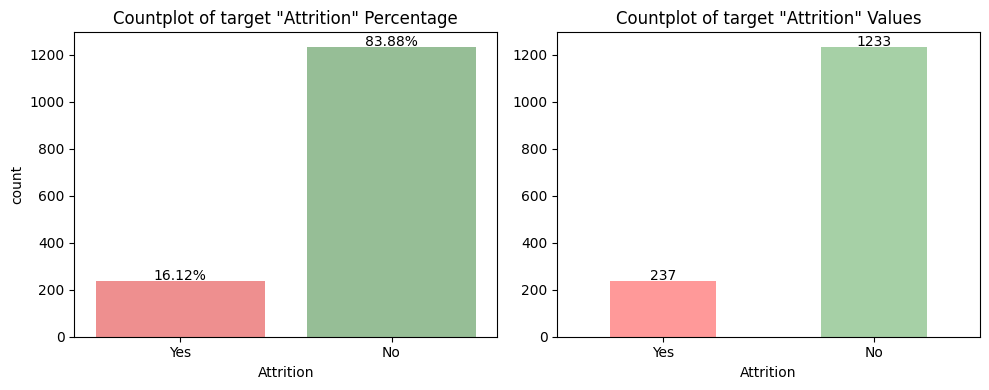

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Percentage target countplot
sns.countplot(x='Attrition', data=df, hue='Attrition', palette={'Yes': 'red', 'No': 'forestgreen'},alpha=0.5, ax=axs[0])

total = len(df['Attrition'])

for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x() + p.get_width() / 2., height + 3, '{:.2f}%'.format((height / total) * 100), ha="center")

axs[0].set_title('Countplot of target "Attrition" Percentage')

# Target countplot
attrition_counts = df['Attrition'].value_counts().sort_index(ascending=False)
attrition_counts.plot(kind='bar', color=['red', 'forestgreen'], alpha=0.4, ax=axs[1])

for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + 3), ha='center')

axs[1].set_title('Countplot of target "Attrition" Values')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


Due to the imbalance in the target variable, it will be necessary to balance the data during the preprocessing phase using techniques such as SMOTE.

## Distribution of features

In [12]:
numeric_columns = []
categorical_columns = []

for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        numeric_columns.append(column)
    elif column != 'Attrition':
        categorical_columns.append(column)

### Numerical

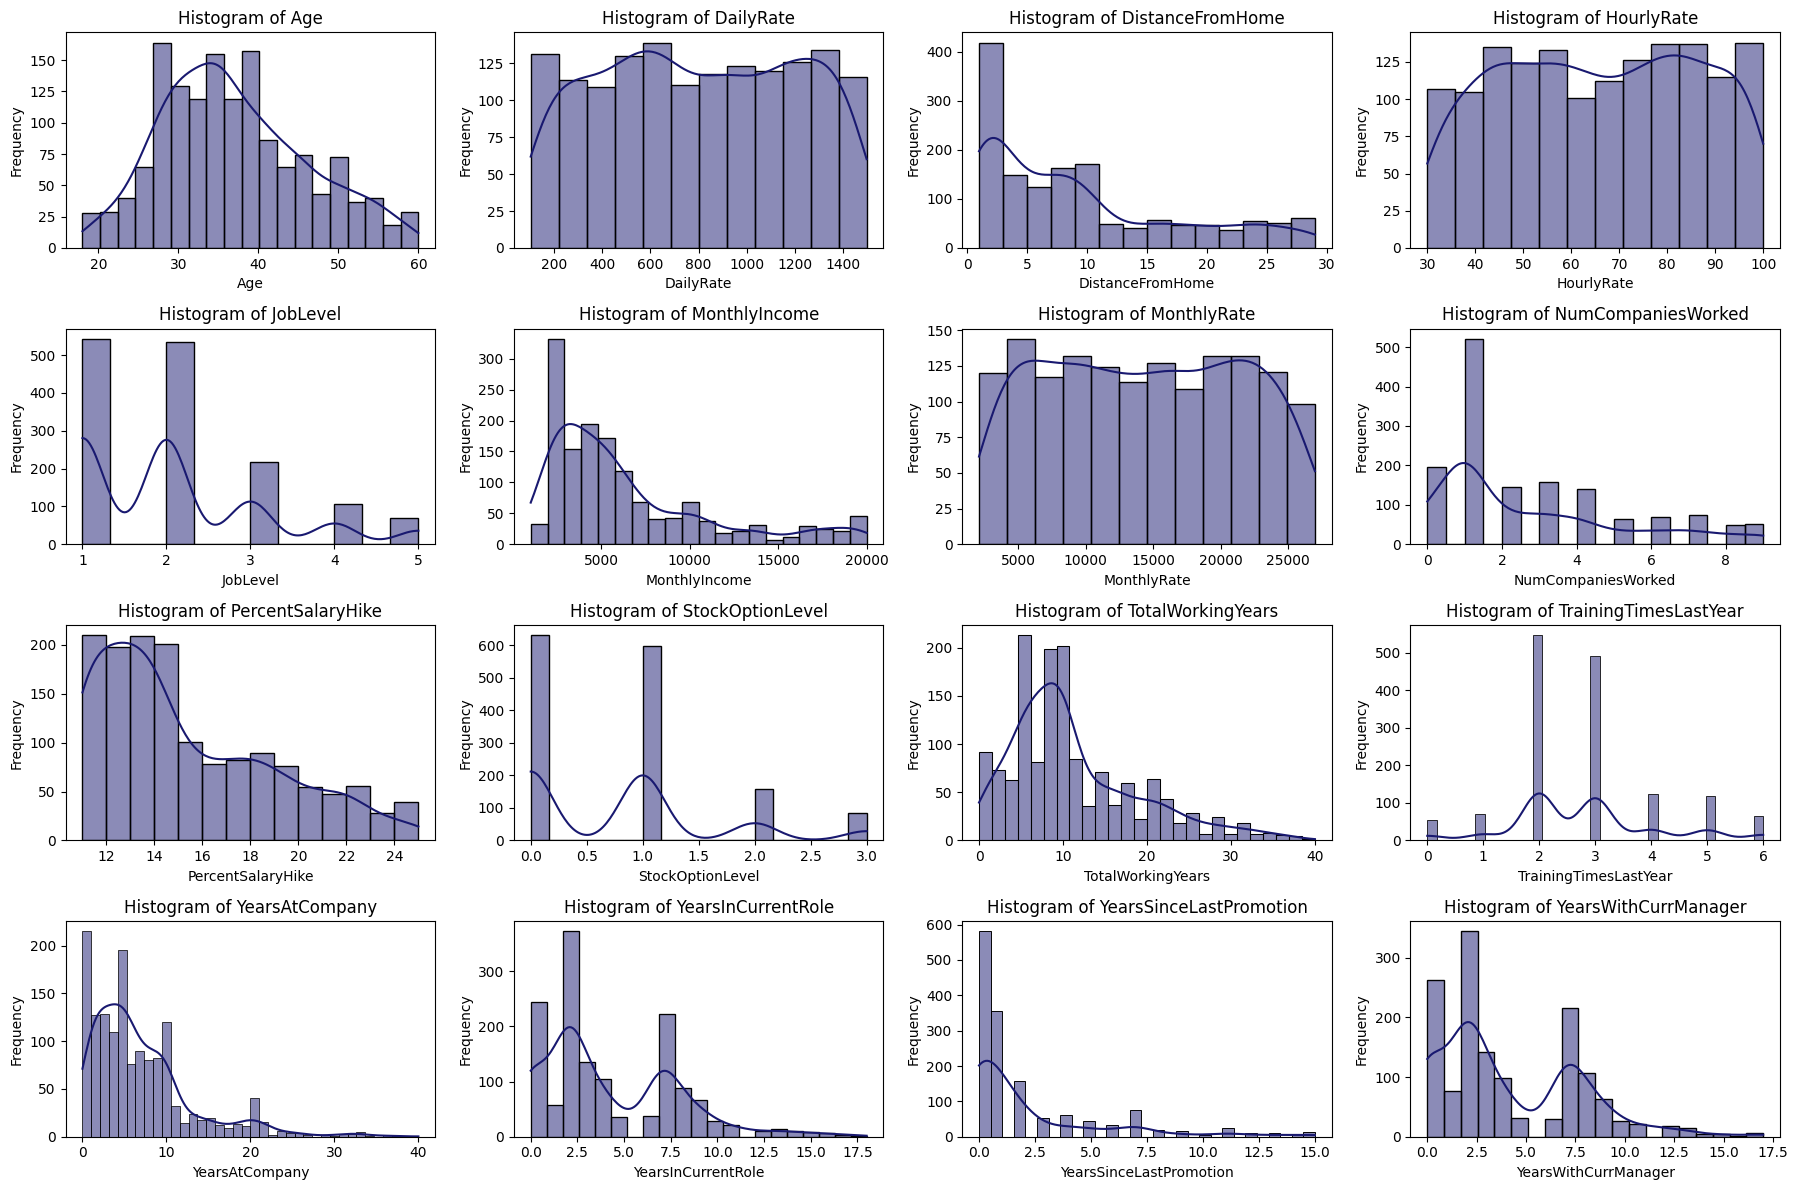

In [13]:
num_plots_per_line = 4
num_lines = math.ceil(len(numeric_columns) / num_plots_per_line)
fig, axes = plt.subplots(num_lines, num_plots_per_line, figsize=(18, num_lines*3))
for i, column in enumerate(numeric_columns):
    row = i // num_plots_per_line
    col = i % num_plots_per_line
    sns.histplot(df[column], kde=True, color='midnightblue', ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Based on the graphs above, it is evident that:

- The majority of individuals fall within the age group of 25-40.
- Nearly 50% of workers live within a short distance from the office, with a commute of less than or equal to 10 units.
- Income analysis reveals that 60% of individuals earn less than 10k.
- Around 40% of employees have worked for fewer than 1 company, suggesting they are relatively new to the workforce.
- About 30% of individuals have worked for more than 5 companies, indicating greater experience.
- Approximately 60% of workers have remained with the same company for 5 years or less.
- The vast majority (80%) of employees own either 1 or no stocks in the company

### Categorical

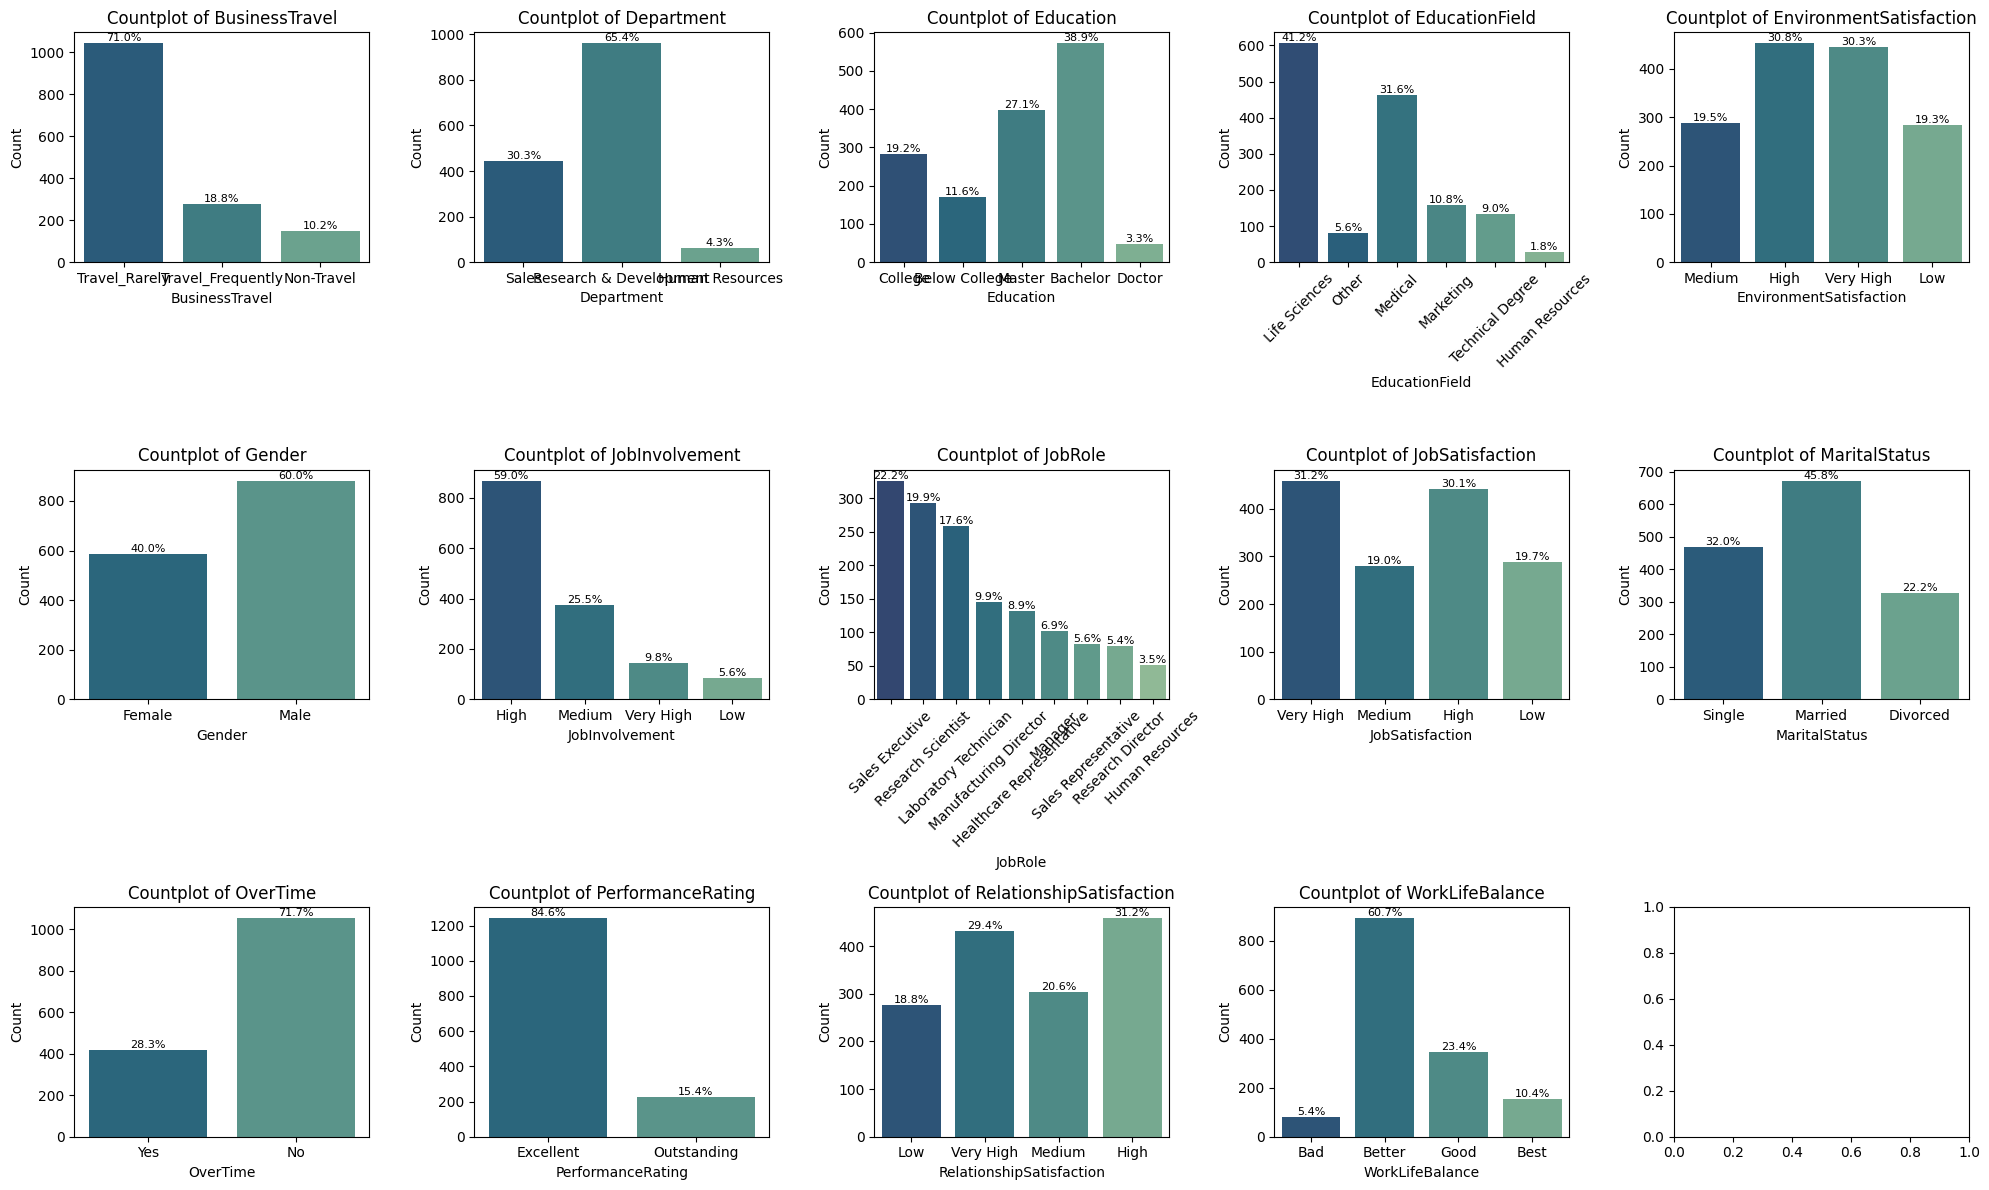

In [14]:
num_plots_per_line_cat = 5
num_lines_cat = math.ceil(len(categorical_columns) / num_plots_per_line_cat)
fig, axes = plt.subplots(num_lines_cat, num_plots_per_line_cat, figsize=(20, num_lines_cat*4))
for i, column in enumerate(categorical_columns):
    row = i // num_plots_per_line_cat
    col = i % num_plots_per_line_cat
    sns.countplot(x=column, data=df, ax=axes[row, col], palette='crest_r')
    axes[row, col].set_title(f'Countplot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')
    if len(df[column].unique()) > 5:
        axes[row, col].tick_params(axis='x', rotation=45)
    
    total = len(df[column])
    for p in axes[row, col].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[row, col].annotate(percentage, (x, y), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

Based on the graphs above, it is evident that:

- Approximately 70% of employees travel rarely, while 20% travel frequently, and the remaining do not travel.
- Over 70% of employees are part of the research and development department.
- More than 60% of individuals possess educational qualifications as Bachelors and Masters.
- The largest proportion (40%) of employees come from the life science field, followed by 30% from the medical field.
- Around 60% of employees are satisfied with the environmental conditions in the office, rating them above High on average.
- Satisfaction with the job is reported by over 60% of employees.
- Gender distribution is approximately 60% male and 40% female.
- A significant portion (60%) of individuals have partial involvement in their job responsibilities, while 20% have high involvement.
- Marriage status shows that 45% of respondents are married, 30% are single, and the remainder are divorced.
- The majority (80%) of employees receive average work ratings.

## Relationship between the target variable and some numerical features

### Attrition vs Monthly Income

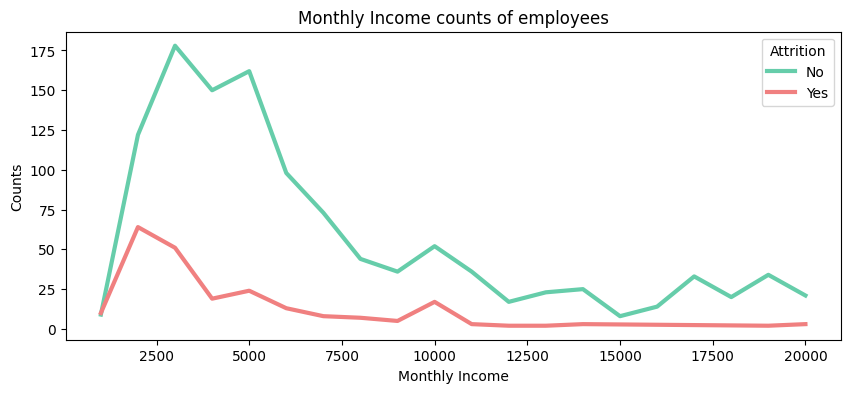

In [15]:
mon_income_att_graph = df.groupby(['MonthlyIncome', 'Attrition']).size().reset_index(name='Counts')

mon_income_att_graph['MonthlyIncome'] = round(mon_income_att_graph['MonthlyIncome'], -3)

mon_income_att_graph = mon_income_att_graph.groupby(['MonthlyIncome', 'Attrition']).size().reset_index(name='Counts')

plt.figure(figsize=(10, 4))
sns.lineplot(data=mon_income_att_graph, x='MonthlyIncome', y='Counts', hue='Attrition', palette={'Yes': 'lightcoral', 'No': 'mediumaquamarine'}, linewidth=3)
plt.title('Monthly Income counts of employees')
plt.xlabel('Monthly Income')
plt.ylabel('Counts')
plt.show()

Based on the chart above, it is observed that the attrition rate is notably high at very low income levels, specifically less than 5k monthly. This decreases further, with a minor spike noticed around 10k, indicating a middle-class livelihood. Individuals in this income range tend to seek better standards of living and consequently move to different jobs. When the monthly income is relatively decent, the likelihood of an employee leaving the organization is low, as indicated by the flat line.

### Attrition vs Age

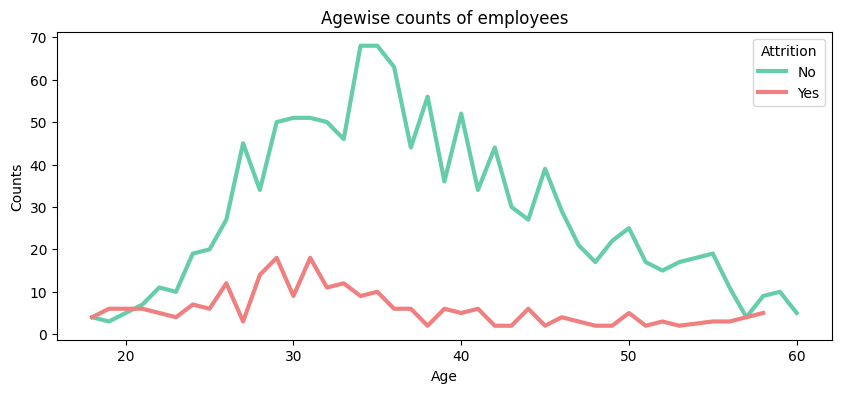

In [16]:
age_att_graph = df.groupby(['Age', 'Attrition']).size().reset_index(name='Counts')

plt.figure(figsize=(10, 4))
sns.lineplot(data=age_att_graph, x='Age', y='Counts', hue='Attrition', palette={'Yes': 'lightcoral', 'No': 'mediumaquamarine'}, linewidth=3)
plt.title('Agewise counts of employees')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.legend(title='Attrition')
plt.show()

Based on the chart above, it is observed that the maximum attrition occurs between the age groups of 28-32. The attrition rate decreases with increasing age, as stability becomes a priority for individuals. Additionally, at a younger age, particularly from 18-20, the likelihood of employees leaving the organization is higher, as they are in an exploratory phase. It reaches a break-even point at the age of 21.

### Attrition vs Years In Current Role

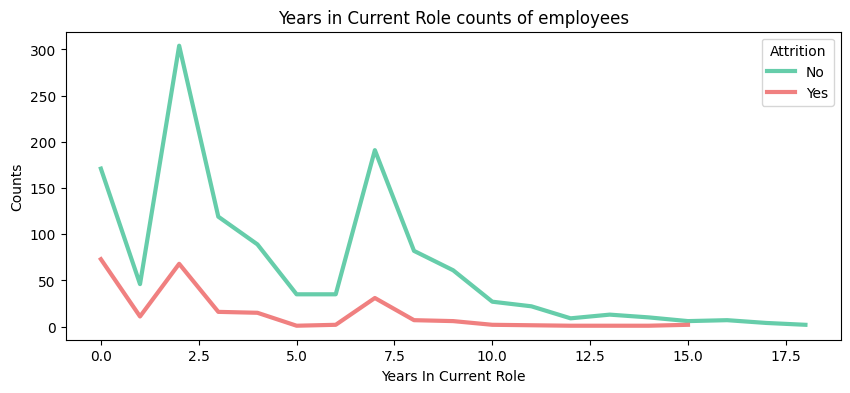

In [17]:
years_curr_role_att_graph = df.groupby(['YearsInCurrentRole', 'Attrition']).size().reset_index(name='Counts')

plt.figure(figsize=(10, 4))
sns.lineplot(data=years_curr_role_att_graph, x='YearsInCurrentRole', y='Counts', hue='Attrition', palette={'Yes': 'lightcoral', 'No': 'mediumaquamarine'}, linewidth=3)
plt.title('Years in Current Role counts of employees')
plt.xlabel('Years In Current Role')
plt.ylabel('Counts')
plt.legend(title='Attrition')
plt.show()

Based on the graph above, it can be analyzed that people are more prone to leave the organization in the starting years of their role. Additionally, when individuals remain in the same role for an extended period, they tend to stay longer before moving into an upward role.

## Relationship between the target variable and some categorical features

### Attrition vs Work Life Balance

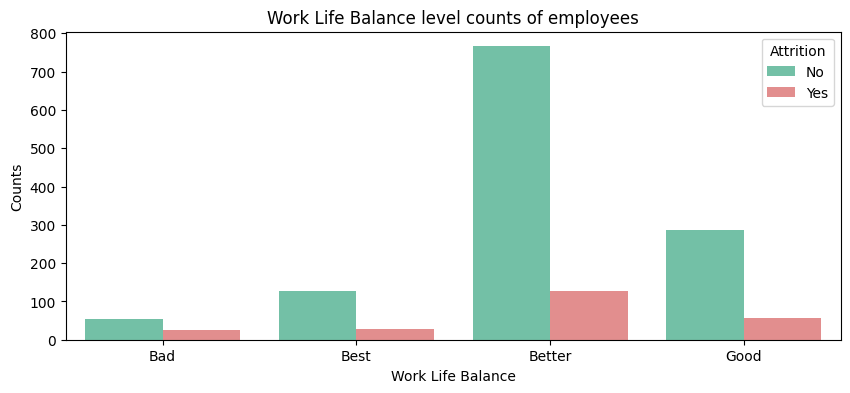

In [18]:
work_life_balanc_att_graph = df.groupby(['WorkLifeBalance', 'Attrition'])['Age'].count().reset_index(name='Counts')

work_life_balanc_att_graph['Attrition Percentage'] = work_life_balanc_att_graph.groupby('WorkLifeBalance')['Counts'].apply(lambda x: 100 * x / float(x.sum()))

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=work_life_balanc_att_graph, x='WorkLifeBalance', y='Counts', hue='Attrition', palette={'Yes': 'lightcoral', 'No': 'mediumaquamarine'})

plt.title('Work Life Balance level counts of employees')
plt.ylabel('Counts')
plt.xlabel('Work Life Balance')
plt.show()

In [19]:
work_life_balanc_att_graph[['WorkLifeBalance','Attrition Percentage']][work_life_balanc_att_graph['Attrition'].eq('Yes')]

,WorkLifeBalance,Attrition Percentage
1,Bad,31.250000
3,Best,17.647059
5,Better,14.221725
7,Good,16.860465


Based on the chart above, it is observed that individuals with lower levels of work-life balance have adapted to their jobs. Conversely, those with higher work-life balance scores tend to lean towards attrition. However, this trend diminishes when work-life balance is excellent, and individuals are satisfied with their work.

### Attrition vs Department

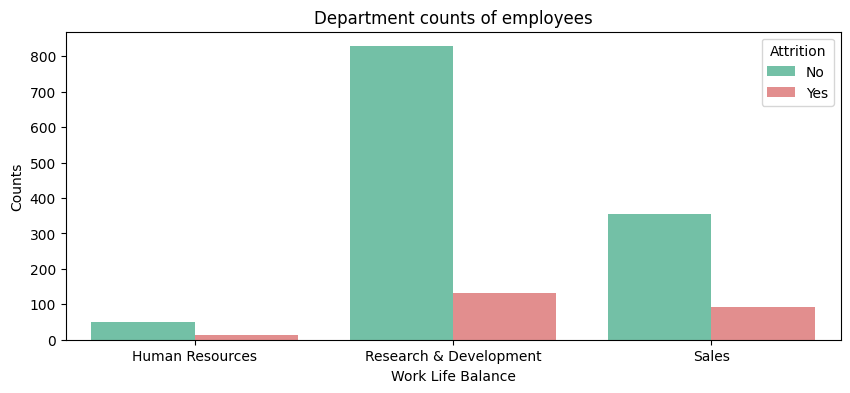

In [20]:
department_att_graph = df.groupby(['Department', 'Attrition'])['Age'].count().reset_index(name='Counts')

department_att_graph['Atrrition Percentage'] = department_att_graph.groupby('Department')['Counts'].apply(lambda x: 100 * x / float(x.sum()))

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=department_att_graph, x='Department', y='Counts', hue='Attrition', palette={'Yes': 'lightcoral', 'No': 'mediumaquamarine'})

plt.title('Department counts of employees')
plt.ylabel('Counts')
plt.xlabel('Work Life Balance')
plt.show()

In [21]:
department_att_graph[['Department','Atrrition Percentage']][department_att_graph['Attrition'].eq('Yes')]

,Department,Atrrition Percentage
1,Human Resources,19.047619
3,Research & Development,13.839750
5,Sales,20.627803


Based on the chart above, it is observed that the data contains only three major departments. The Sales department has the highest attrition rates (20%), followed by the Human Resource Department (19%). Conversely, the Research and Development department exhibits the lowest attrition rates, indicating stability and contentment within the department, as depicted in the chart above (13%).

# Predictive Model

## Encoding

### Ordinal features

In [11]:
ordinal_categ = ['BusinessTravel','Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating','RelationshipSatisfaction','WorkLifeBalance']

le = LabelEncoder()
df[ordinal_categ] = df[ordinal_categ].apply(le.fit_transform)

### Nominal features

In [12]:
df = pd.get_dummies(data=df, columns=['Attrition','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime'], drop_first=True)

# Rename columns name
rename_dummies_columns = {'Attrition_Yes': 'Attrition', 'Gender_Male': 'Gender', 'OverTime_Yes': 'OverTime'}

df.rename(columns=rename_dummies_columns, inplace=True)

### Deleting columns without value after training model

In [13]:
df = df.drop(columns=['JobRole_Research Director', 'JobRole_Manager', 'JobRole_Human Resources','Gender','EducationField_Life Sciences', 'MaritalStatus_Married','JobRole_Laboratory Technician','EducationField_Marketing','PerformanceRating','EducationField_Other','JobRole_Sales Representative','JobRole_Manufacturing Director','MonthlyRate','HourlyRate'])

## Train Test Split

In [14]:
df_train_test = df.sample(frac= 0.95, random_state=42)
df_validate = df.drop(df_train_test.index)

df_train_test.reset_index(drop=True, inplace= True)
df_validate.reset_index(drop=True, inplace= True)

print('95% of data for modeling:', df_train_test.shape)
print('05% of data for validate:', df_validate.shape)

95% of data for modeling: (1396, 30)
05% of data for validate: (74, 30)


In [15]:
X = df_train_test.drop(columns=['Attrition'])
y = df_train_test['Attrition']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1116, 29)
(1116,)
(280, 29)
(280,)


## Pipeline (Class balancing, Scaling, Cross-validating and Tune)

In [17]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('SVC', SVC(probability=True)),
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('LGBM', LGBMClassifier(verbose=-1)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# Define cross-validation metrics
cross_val_metrics = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# List to store results
results = []

# Dictionary to store best estimators
best_estimators = {}

# Define StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over the models
for name, model in models:
    # Define the pipeline
    pipeline = imbpipeline(steps=[
        ['nearmiss', NearMiss()],
        ['scaler', StandardScaler()],
        ['classifier', model]
    ])
    
    # Define the parameter grid specific to each model
    if name == 'Logistic Regression':
        param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                      'classifier__max_iter': [100, 300, 500, 1000],
                      'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                      'classifier__solver': ['lbfgs','newton-cg','liblinear','sag','saga']}
    elif name == 'SVC':
        param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100], 
                      'classifier__kernel': ['linear', 'rbf']}
    elif name == 'K-Nearest Neighbors':
        param_grid = {'classifier__n_neighbors': [3, 5, 7, 9]}
    elif name == 'Decision Tree':
        param_grid = {'classifier__max_depth': [None, 5, 10]}
    elif name == 'Random Forest':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__max_depth': [None, 5, 10]}
    elif name == 'Gradient Boosting':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__learning_rate': [0.01, 0.1, 0.2], 
                      'classifier__max_depth': [3, 5, 7]}
    elif name == 'LGBM':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__learning_rate': [0.01, 0.1, 0.2], 
                      'classifier__max_depth': [3, 5, 7]}
    elif name == 'XGBoost':
        param_grid = {'classifier__n_estimators': [50, 100, 200], 
                      'classifier__learning_rate': [0.01, 0.1, 0.2], 
                      'classifier__max_depth': [3, 5, 7]}
    else:
        param_grid = {}

    # Create the GridSearchCV with refit on 'recall'
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring=cross_val_metrics,
                               refit='recall',
                               cv=stratified_kfold,
                               n_jobs=-1)

    # Fit the GridSearchCV on the training data
    grid_search.fit(X_train, y_train)

    # Save the best estimator for the current model
    best_estimators[name] = grid_search.best_estimator_['classifier']

    # Evaluate the best model on the test set for all metrics
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

    test_scores = {
        'accuracy': round(accuracy_score(y_test, y_pred), 3),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'f1': round(f1_score(y_test, y_pred), 3),
        'roc_auc': round(roc_auc_score(y_test, y_pred_proba), 3)
    }

    # Add results to the DataFrame
    results.append({
        'model': name,
        **test_scores
    })

## Evaluation

In [18]:
df_model_comparison = pd.DataFrame(results)

df_model_comparison.sort_values(by='recall',ascending=False)

,model,accuracy,precision,recall,f1,roc_auc
8,XGBoost,0.514,0.220,0.818,0.346,0.646
5,Random Forest,0.539,0.222,0.773,0.345,0.630
6,Gradient Boosting,0.514,0.212,0.773,0.333,0.642
7,LGBM,0.504,0.209,0.773,0.329,0.647
4,Decision Tree,0.475,0.188,0.705,0.297,0.568
1,SVC,0.514,0.193,0.659,0.299,0.656
3,K-Nearest Neighbors,0.589,0.211,0.591,0.311,0.636
2,Naive Bayes,0.511,0.161,0.500,0.243,0.508
0,Logistic Regression,0.843,0.000,0.000,0.000,0.500


In [19]:
best_model = best_estimators['Random Forest']
print(best_model)

RandomForestClassifier(n_estimators=200)


In [20]:
final_pipeline = imbpipeline(steps=[
                            ['nearmiss', NearMiss()],
                            ['scaler', StandardScaler()],
                            ['classifier', best_model]
                    ])

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.45      0.60       236
           1       0.19      0.70      0.30        44

    accuracy                           0.49       280
   macro avg       0.54      0.58      0.45       280
weighted avg       0.78      0.49      0.55       280



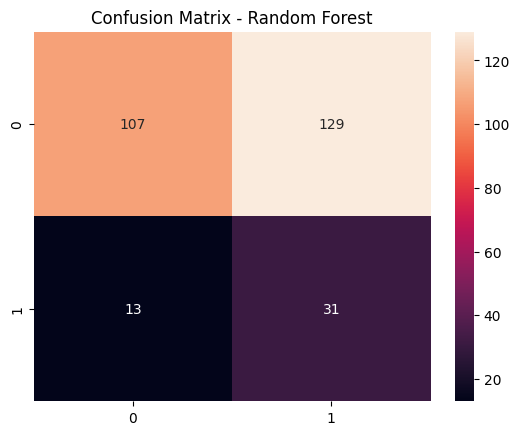

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.title('Confusion Matrix - Random Forest');

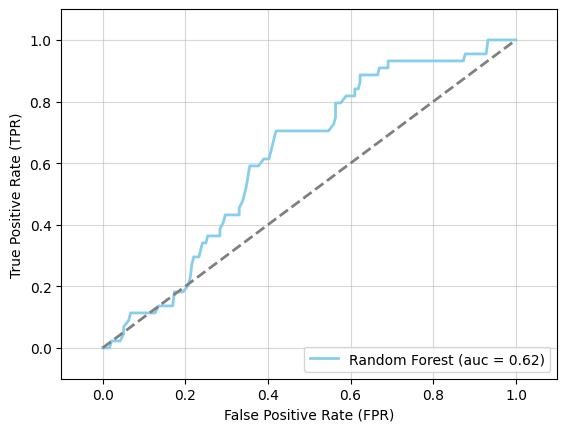

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'Random Forest (auc = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

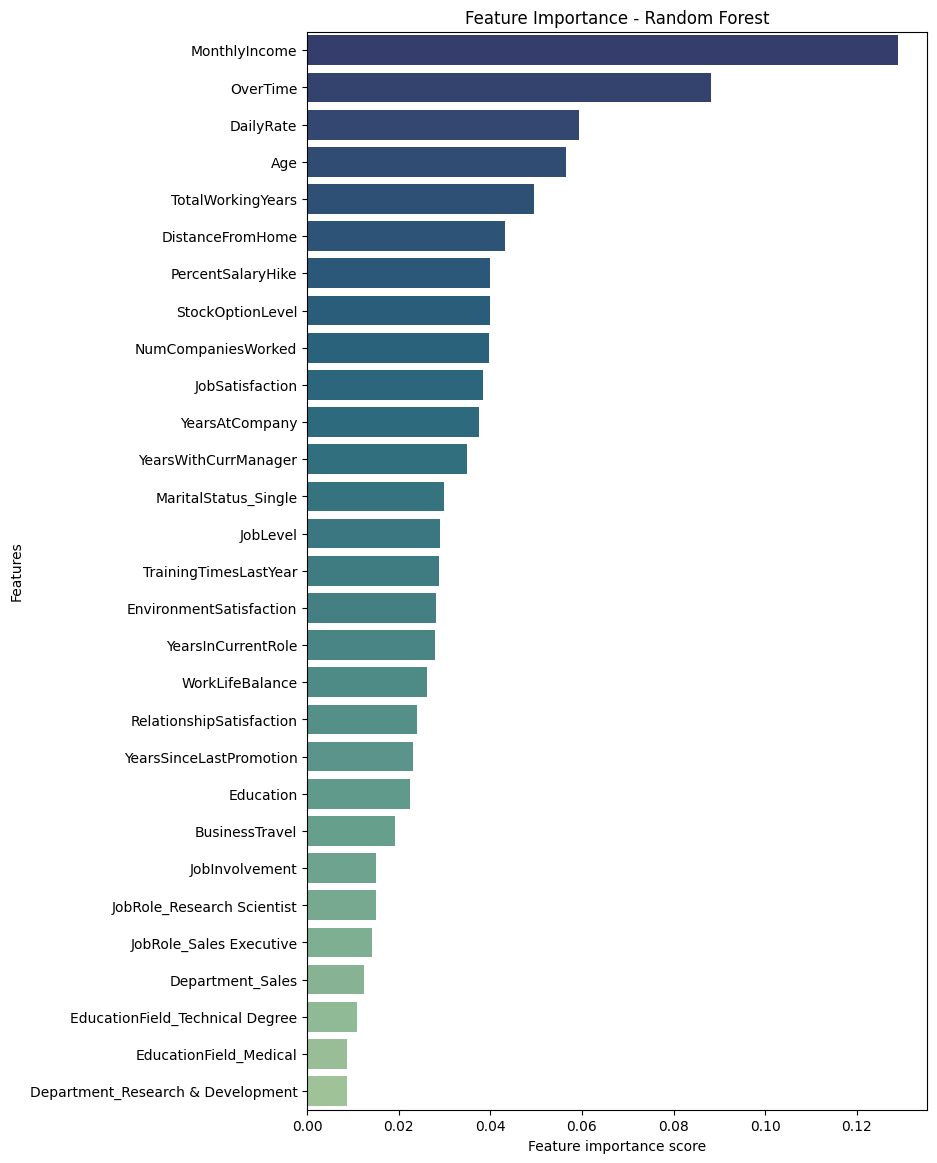

In [24]:
feature_scores = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(8, 14))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, palette='crest_r')
ax.set_title("Feature Importance - Random Forest")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## Save model

In [26]:
pickle.dump(best_model, open('./model_rf.pkl', 'wb'))

In [28]:
df_validate.drop(columns=['Attrition']).to_csv('./Xtest.csv', index=False)